In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as ss

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words

# Ensure required NLTK resources are downloaded
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('words')

except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# Define stopwords list
specific_stopwords = ["https", "subreddit", "www", "com"] ## some specific words for the given dataset
stopwords_list = stopwords.words('english') +specific_stopwords + stopwords.words('french') # dataset is both in english and in french


[nltk_data] Downloading package punkt to /home/clatimie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clatimie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/clatimie/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# Define the path to the training data file
path_training = "../datasets/Train.csv"

# Read the CSV file into a pandas DataFrame
training_data = pd.read_csv(path_training, delimiter=',')

# Set column names explicitly for better readability
training_data.columns = ['text', 'subreddit']

# Shuffle dataset
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True) 

# Separate the training data into two series: texts and subreddit labels
x_train = training_data['text']          # Contains the Reddit posts or comments
y_train = training_data['subreddit'] # Contains the subreddit each post originates from

# Get unique subreddit labels
unique_labels = np.unique(y_train)   # List of unique subreddits in the dataset

n_samples_training = x_train.shape[0]
n_classes = unique_labels.shape[0]

print(f"Training dataset has {n_samples_training} examples and there are {n_classes} classes")

Training dataset has 1399 examples and there are 4 classes


In [3]:
# Define the path to the training data file
path_test = "../datasets/Test.csv"

# Read the CSV file into a pandas DataFrame
x_test = pd.read_csv(path_test, delimiter=',')["body"]

n_samples_test = x_test.shape[0]
print(f"Test dataset has {n_samples_test} examples")


Test dataset has 600 examples


In [4]:
class LemmaTokenizer:
    def __init__(self, stopwords=None):
        self.wnl = WordNetLemmatizer()
        self.stop_words = stopwords

    def __call__(self, doc):
        # Tokenize the document and apply lemmatization and filtering
        return [
            self.wnl.lemmatize(t, pos="v") for t in word_tokenize(doc)
            if t.isalpha() and t.lower() not in self.stop_words]

# SVC method #

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

vectorizer = TfidfVectorizer(
    lowercase=True,
    tokenizer=LemmaTokenizer(stopwords=stopwords_list)
)

x_train_tfidf = vectorizer.fit_transform(x_train)
selector = SelectKBest(mutual_info_classif, k=3000)
x_train_mi = selector.fit_transform(x_train_tfidf, y_train)
scaler = StandardScaler()
x_train_svc = scaler.fit_transform(np.asarray(x_train_mi.todense()))

classifier = SVC(kernel="rbf")

# 10 Fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []

for train_index, val_index in kf.split(x_train_svc):
    X_train_fold, X_val_fold = x_train_svc[train_index], x_train_svc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
    # Train best binary SVM classifier
    classifier.fit(X_train_fold, y_fold_train)
        
    # Predict and evaluate on validation set
    y_pred = classifier.predict(X_val_fold)
    accuracy = accuracy_score(y_fold_val, y_pred)
    accuracies.append(accuracy)
        
    # Display results for each fold
    print(f"Accuracy for fold: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_fold_val, y_pred))

    # Calculate and display mean accuracy
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy across 10 folds for best binary classifier: {mean_accuracy:.4f}")



/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/home/clatimie/myenv/lib/pyt

Accuracy for fold: 0.7643
Classification Report:
               precision    recall  f1-score   support

    Brussels       0.69      0.87      0.77        38
      London       0.71      0.84      0.77        32
    Montreal       0.90      0.59      0.72        32
     Toronto       0.85      0.74      0.79        38

    accuracy                           0.76       140
   macro avg       0.79      0.76      0.76       140
weighted avg       0.79      0.76      0.76       140

Mean Accuracy across 10 folds for best binary classifier: 0.7643
Accuracy for fold: 0.6429
Classification Report:
               precision    recall  f1-score   support

    Brussels       0.62      0.70      0.66        37
      London       0.50      0.56      0.53        36
    Montreal       0.93      0.50      0.65        28
     Toronto       0.70      0.77      0.73        39

    accuracy                           0.64       140
   macro avg       0.69      0.63      0.64       140
weighted avg       0

# SVC - Two classifiers method #

In [ ]:
if False:
    #################################################################### Classifier 1 : Montreal or Not ######################################################################
    # Best parameters found : max_features = 1000, svm_C = 10, kernel="rbf", svm_gamma = 'scale'

    # Convert y_train to binary labels for the first classifier
    y_binary = np.array([1 if label == "Montreal" else 0 for label in y_train])

    TfidfVectorizer1 = TfidfVectorizer(
        lowercase=True,
        max_features=1000,
        tokenizer=LemmaTokenizer(stopwords_list)
    )

    x_tfidf1 = TfidfVectorizer1.fit_transform(x_train)
    scaler1 = StandardScaler()
    x_scaled_1 = scaler1.fit_transform(np.asarray(x_tfidf1.todense()))

    binary_svm = SVC(C=10.0, kernel="rbf", gamma="scale")

    # 10 Fold cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(x_scaled_1):
        X_train_fold, X_val_fold = x_scaled_1[train_index], x_scaled_1[val_index]
        y_fold_train, y_fold_val = y_binary[train_index], y_binary[val_index]
        
        # Train best binary SVM classifier
        binary_svm.fit(X_train_fold, y_fold_train)
        
        # Predict and evaluate on validation set
        y_pred = binary_svm.predict(X_val_fold)
        accuracy = accuracy_score(y_fold_val, y_pred)
        accuracies.append(accuracy)
        
        # Display results for each fold
        print(f"Accuracy for fold: {accuracy:.4f}")
        print("Classification Report:\n", classification_report(y_fold_val, y_pred))

    # Calculate and display mean accuracy
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy across 10 folds for best binary classifier: {mean_accuracy:.4f}")

    #################################################################### Classifier 2 : Other subreddits ######################################################################

    # Best parameters for multi-class SVM: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'tfidf__max_features': 4000}

    # Filter for "Not Montreal" entries for the second classifier
    x_not_montreal = np.array(x_train)[y_binary == 0]
    y_not_montreal = np.array(y_train)[y_binary == 0]

    TfidfVectorizer2 = TfidfVectorizer(
        lowercase=True,
        max_features=4000,
        stop_words=stopwords_list
    )
    x_tfidf2 = TfidfVectorizer2.fit_transform(x_not_montreal)
    scaler2 = StandardScaler()
    x_scaled_2 = scaler2.fit_transform(np.asarray(x_tfidf2.todense()))

    multi_class_svm = LogisticRegression()

    accuracies = []

    for train_index, val_index in kf.split(x_scaled_2):
        X_train_fold, X_val_fold = x_scaled_2[train_index], x_scaled_2[val_index]
        y_fold_train, y_fold_val = y_not_montreal[train_index], y_not_montreal[val_index]
        
        # Train best multi-class SVM on non-Montreal data
        multi_class_svm.fit(X_train_fold, y_fold_train)
        
        # Predict and evaluate on validation set
        y_pred = multi_class_svm.predict(X_val_fold)
        accuracy = accuracy_score(y_fold_val, y_pred)
        accuracies.append(accuracy)
        
        # Display results for each fold
        print(f"Accuracy for fold: {accuracy:.4f}")
        print("Classification Report:\n", classification_report(y_fold_val, y_pred))

    # Calculate and display mean accuracy for the multi-class classifier
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy across 10 folds for best multi-class classifier: {mean_accuracy:.4f}")

    ################################################################################ Fit the two classifiers with the whole dataset #########################################
    binary_svm.fit(x_scaled_1, y_binary)
    multi_class_svm.fit(x_scaled_2, y_not_montreal)

    ######################################################################### Save predictions in a csv file ##############################################################
    def predict_subreddits_SVC(x_test, binary_model, multi_class_model, vectorizer_binary, vectorizer_multiclass, scaler_binary, scaler_multiclass):
        """
        Predicts the location for a given array of texts using a binary and multi-class model.
        Saves predictions in a CSV file with 'id' and 'subreddit' columns.

        Parameters:
        - x_test (array-like): Array of text inputs to predict.
        - binary_model (sklearn model): Fitted binary SVM model.
        - multi_class_model (sklearn model): Fitted multi-class SVM model.
        - vectorizer_binary (TfidfVectorizer): Fitted TF-IDF vectorizer for binary model.
        - vectorizer_multiclass (TfidfVectorizer): Fitted TF-IDF vectorizer for multi-class model.
        - scaler_binary (StandardScaler): Fitted scaler for binary model.
        - scaler_multiclass (StandardScaler): Fitted scaler for multi-class model.

        Returns:
        - DataFrame: Prediction results with 'id' and 'subreddit' columns.
        """
        # Step 1: Transform texts using the vectorizer and scaler for binary model
        x_test_tfidf1 = vectorizer_binary.transform(x_test)
        x_test_scaled_1 = scaler_binary.transform(np.asarray(x_test_tfidf1.todense()))
        
        # Step 2: Predict with the binary model to identify "Montreal" vs "Not Montreal"
        binary_predictions = binary_model.predict(x_test_scaled_1)
        
        # Step 3: Prepare to apply multi-class model only to "Not Montreal" entries
        not_montreal_mask = (binary_predictions == 0)  # Mask for "Not Montreal" entries
        x_test_not_mtl = x_test[not_montreal_mask]

        # Step 4: Transform "Not Montreal" texts using multi-class vectorizer
        x_test_tfidf2 = vectorizer_multiclass.transform(x_test_not_mtl)
        x_test_scaled_2 = scaler_multiclass.transform(np.asarray(x_test_tfidf2.todense()))
        
        # Apply multi-class model only to the "Not Montreal" subset
        multi_class_predictions = multi_class_model.predict(x_test_scaled_2)
        
        # Step 5: Combine predictions for both "Montreal" and multi-class predictions
        predictions = []
        
        # Add "Montreal" predictions
        for pred in binary_predictions:
            if pred == 1:
                predictions.append("Montreal")
            else:
                predictions.append(None)  # Placeholder for "Not Montreal" predictions
                
        # Replace None with multi-class predictions for "Not Montreal" entries
        not_montreal_indices = [i for i, pred in enumerate(binary_predictions) if pred == 0]
        for idx, multi_pred in zip(not_montreal_indices, multi_class_predictions):
            predictions[idx] = multi_pred
        
        # Step 6: Create DataFrame for results
        results_df = pd.DataFrame({
            'id': range(len(x_test)),
            'subreddit': predictions
        })
        
        # Step 7: Save to CSV
        results_df.to_csv("../output/submissions_two_layer_svm.csv", index=False)
        
        return results_df


   # predict_subreddits_SVC(x_test, binary_svm, multi_class_svm, TfidfVectorizer1, TfidfVectorizer2, scaler1, scaler2)



In [ ]:
import langid
def classify_language(comment):
    language, _ = langid.classify(comment)
    return 'Montreal (english)' if language == 'en' else 'Montreal (french)' if language == 'fr' else 'Montreal (english)'

# Modify the labels for comments in the Montreal class
subreddits_mtl_distinct = []  # To hold modified labels

for comment, label in zip(x_train, y_train):
    if label == 'Montreal':
        language = classify_language(comment)
        subreddits_mtl_distinct.append(language)
    else:
        subreddits_mtl_distinct.append(label)

def plot_most_distinctive_words_frequency(top_n_plot, texts_train, y_train, top_n_selected, plots=True):
    unique_labels = sorted(set(y_train))  # Get unique classes
    label_texts = {label: [] for label in unique_labels}  # Dictionary to hold texts per class

    # Separate texts by label
    for text, label in zip(texts_train, y_train):
        label_texts[label].append(text)

    # Fit CountVectorizer with the custom tokenizer
    vectorizer = CountVectorizer(
        token_pattern=r'\b[a-zA-Z]{2,}\b',
        stop_words=stopwords_list,
        tokenizer=LemmaTokenizer(stopwords=stopwords_list),
        strip_accents="unicode"
    )
    
    vectorizer.fit(texts_train)
    feature_names = vectorizer.get_feature_names_out()

    # Initialize a dictionary to store word frequencies per class
    word_frequencies = {label: np.zeros(len(feature_names)) for label in unique_labels}

    # Calculate word frequencies for each word in each class
    for label in unique_labels:
        count_matrix = vectorizer.transform(label_texts[label])
        word_frequencies[label] = np.array(count_matrix.sum(axis=0)).flatten()

    # List to hold the top distinctive words across all classes
    all_distinctive_words = []

    if plots:
        # Set up the figure with subplots
        n_labels = len(unique_labels)
        n_cols = 2  # Number of columns for subplots
        n_rows = (n_labels + n_cols - 1) // n_cols  # Calculate number of rows required
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))  # Adjust grid size
        axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, label in enumerate(unique_labels):
        # Calculate distinctiveness by comparing word frequency of this class to the average in other classes
        other_classes = [lbl for lbl in unique_labels if lbl != label]

        if label == "montreal_english":
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes if other_label != "montreal_french"], axis=0)
        elif label == "montreal_french":
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes if other_label != "montreal_english"], axis=0)
        else:
            avg_freq_other_classes = np.mean([word_frequencies[other_label] for other_label in other_classes], axis=0)

        # Calculate distinctiveness score (frequency in this class minus average frequency in other classes)
        distinctiveness_scores = word_frequencies[label] - avg_freq_other_classes

        # Get the indices of the top N distinctive words
        if label == "montreal_english" or label == "montreal_french":
            top_n_selected_mtl = int(top_n_selected*0.6)
            top_indices = np.argsort(distinctiveness_scores)[-top_n_selected_mtl:][::-1]  # Indices of top N scores in descending order
        else:
            top_indices = np.argsort(distinctiveness_scores)[-top_n_selected:][::-1]  # Indices of top N scores in descending order

        # Select the top N distinctive words and their scores
        distinctive_words = [feature_names[idx] for idx in top_indices]
        distinctive_scores = [distinctiveness_scores[idx] for idx in top_indices]

        # Extend the all_distinctive_words list with the current class's words
        all_distinctive_words.extend(distinctive_words)

        if plots:
            ax = axes[i]
            ax.barh(distinctive_words[0:top_n_plot], distinctive_scores[0:top_n_plot], color='skyblue')
            ax.set_xlabel("Frequency Difference")
            ax.set_title(f"Top {top_n_plot} distinctive words for class '{label}'")
            ax.invert_yaxis()  # Invert y-axis to have the most distinctive words on top
            # Adjust layout and show the figure
    if plots:
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        plt.tight_layout()
        plt.show()

    # Return the merged list of top distinctive words across all classes
    return list(set(all_distinctive_words))  # Convert to set to remove duplicates and back to list


# Neural Network #

In [ ]:
if False:
    # Build the network
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras import initializers

    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras import regularizers

    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.models import clone_model
    from tensorflow.keras.callbacks import ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.metrics import Precision, Recall

    import os
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras import models, layers, initializers, regularizers
    from tensorflow.keras.layers import BatchNormalization

    # Set seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    def sigmoid(z):
        return 1 / (1 + tf.exp(-z))

    def classifier_model(layer_size, num_layers, activation, input_dim, dropout_rate=0.7):
        # Set a specific initializer with a fixed seed
        initializer = initializers.RandomNormal(mean=0., stddev=0.01, seed=10)
        
        network = models.Sequential()
        network.add(layers.Dense(layer_size, 
                                input_dim=input_dim, 
                                activation=activation, 
                                kernel_initializer=initializer,
                                kernel_regularizer=regularizers.l2(0.05)))

        for _ in range(num_layers):
            network.add(layers.Dense(layer_size, 
                                    activation=activation, 
                                    kernel_initializer=initializer,
                                    kernel_regularizer=regularizers.l2(0.05)))
            network.add(BatchNormalization())
            network.add(layers.Dropout(dropout_rate, seed=42))

        network.add(layers.Dense(4, activation='softmax', kernel_initializer=initializer))
        network.compile(optimizer='Adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
        
        return network

    # Use distinctiveness
    vocab = np.unique(np.array(plot_most_distinctive_words_frequency(20, x_train, subreddits_mtl_distinct, top_n_selected=1000, plots=False)))

    vectorizer = TfidfVectorizer(
        binary=True, # vectorized vector must be binary for Naive Bayes
        lowercase=True, # words must be in lowercases
        vocabulary=vocab
    )

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)  
    y_train_cat = to_categorical(y_train_encoded, num_classes=4)  


    x_tfidf_train_nn = vectorizer.fit_transform(x_train)  
    scaler_nn = StandardScaler()
    x_scaled_train_nn = scaler_nn.fit_transform(np.asarray(x_tfidf_train_nn.todense())) 

    model_1 = classifier_model(
        layer_size=400, 
        num_layers=5,
        input_dim=x_scaled_train_nn.shape[1],
        dropout_rate=0.8,
        activation="sigmoid"
    )

    # Callbacks for training
    reduce_lr_accu = ReduceLROnPlateau(
        monitor='accuracy',   # Monitor validation accuracy
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    reduce_lr_loss = ReduceLROnPlateau(
        monitor='loss',   # Monitor F1 score
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    # Lists to store accuracies for each fold
    train_accuracies = []
    val_accuracies = []

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kf.split(x_scaled_train_nn), 1):
        print(f"Training fold {fold}...")
        
        # Split data
        X_train_fold, X_val_fold = x_scaled_train_nn[train_index], x_scaled_train_nn[val_index]
        y_train_fold, y_val_fold = y_train_cat[train_index], y_train_cat[val_index]
        
        # Clone and compile model with a lower learning rate
        model_fold = clone_model(model_1)
        model_fold.set_weights(model_1.get_weights())
        model_fold.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Fit with callbacks
        history = model_fold.fit(
            X_train_fold, 
            y_train_fold, 
            epochs=30, 
            batch_size=32, 
            verbose=1, 
            validation_data=(X_val_fold, y_val_fold), 
            callbacks=[reduce_lr_accu, reduce_lr_accu]
        )
        
        # Record accuracies
        train_accuracies.append(history.history['accuracy'][-1])
        val_accuracies.append(history.history['val_accuracy'][-1])
        
        print(f"Fold {fold} - Validation Accuracy: {val_accuracies[-1]:.4f}")

    # Plot accuracy across folds
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='x', linestyle='--', color='r', label='Training Accuracy')
    plt.title('Training and Validation Accuracy Across Folds')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f}")

    ### Prediction phase

    # Step 1: Transform x_test to TF-IDF format and scale it
    x_tfidf_test_nn = vectorizer.transform(x_test)  # Transform test data with the same TF-IDF vectorizer
    x_scaled_test_nn = scaler_nn.transform(np.asarray(x_tfidf_test_nn.todense()))  # Scale the test data

    model = clone_model(model_1)
    model.set_weights(model_1.get_weights())
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_scaled_train_nn, y_train_cat, epochs=30, batch_size=32, verbose=1,  callbacks=[reduce_lr_accu, reduce_lr_accu])  # Adjust epochs and batch size

    predictions = model.predict(x_scaled_test_nn)  # Predict with the model on the test set
    predicted_class_indices = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

    results_df = pd.DataFrame({'id': range(len(x_test)), 'subreddit': predicted_labels})

    # Step 6: Save the results to a CSV file
    results_df.to_csv("../output/subreddit_predictions_NN.csv", index=False)
    print("Predictions saved to  ../output/subreddit_predictions_NN.csv")





2024-11-13 17:02:16.994781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 17:02:16.995596: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 17:02:16.999042: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 17:02:17.006020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731535337.020812   85003 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731535337.02

/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/clatimie/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fume', 'futes', 'meme', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(
/home/clatimie/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs

Training fold 1...
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.2772 - loss: 9.9073 - val_accuracy: 0.2714 - val_loss: 8.0794 - learning_rate: 0.0010
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4631 - loss: 7.7626 - val_accuracy: 0.2714 - val_loss: 6.9216 - learning_rate: 0.0010
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6979 - loss: 5.7943 - val_accuracy: 0.2714 - val_loss: 5.1739 - learning_rate: 0.0010
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7845 - loss: 4.1340 - val_accuracy: 0.2286 - val_loss: 4.5267 - learning_rate: 0.0010
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7668 - loss: 3.6526 - val_accuracy: 0.2714 - val_loss: 4.1265 - learning_rate: 0.0010
Epoch 6/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7728 - loss: 3.2855
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7728 - loss

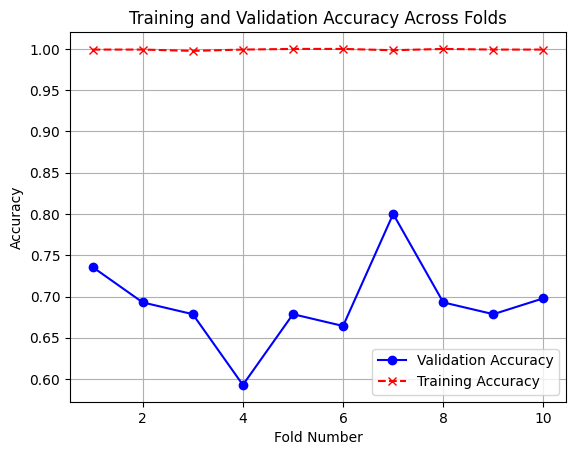

Mean Validation Accuracy: 0.6912
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2535 - loss: 9.7972 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4546 - loss: 7.6002 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7913 - loss: 5.1742 - learning_rate: 0.0010
Epoch 4/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8036 - loss: 3.9206
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8032 - loss: 3.9148 - learning_rate: 0.0010
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7991 - loss: 3.4321 - learning_rate: 5.0000e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8910 - loss: 2.5635 - learning_rate: 5.0000e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9125 - loss: 1.9840 - learning_rate: 5.0000e-04
Epoch 8/30
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Use distinctiveness
vocab = np.unique(np.array(plot_most_distinctive_words_frequency(20, x_train, subreddits_mtl_distinct, top_n_selected=1000, plots=False)))

vectorizer = TfidfVectorizer(
    binary=True, # vectorized vector must be binary for Naive Bayes
    lowercase=True, # words must be in lowercases
    vocabulary=vocab
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  
y_train_cat = to_categorical(y_train_encoded, num_classes=4)  


x_tfidf_train_nn = vectorizer.fit_transform(x_train)  
scaler_nn = StandardScaler()
x_scaled_train_nn = scaler_nn.fit_transform(np.asarray(x_tfidf_train_nn.todense())) 

model_1 = classifier_model(
    layer_size=400, 
    num_layers=5,
    input_dim=x_scaled_train_nn.shape[1],
    dropout_rate=0.8,
    activation="sigmoid"
)

# Callbacks for training
reduce_lr_accu = ReduceLROnPlateau(
    monitor='accuracy',   # Monitor validation accuracy
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

reduce_lr_loss = ReduceLROnPlateau(
    monitor='loss',   # Monitor F1 score
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)



# Lists to store accuracies for each fold
train_accuracies = []
val_accuracies = []

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(x_scaled_train_nn), 1):
    print(f"Training fold {fold}...")
    
    # Split data
    X_train_fold, X_val_fold = x_scaled_train_nn[train_index], x_scaled_train_nn[val_index]
    y_train_fold, y_val_fold = y_train_cat[train_index], y_train_cat[val_index]
    
    # Clone and compile model with a lower learning rate
    model_fold = clone_model(model_1)
    model_fold.set_weights(model_1.get_weights())
    model_fold.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit with callbacks
    history = model_fold.fit(
        X_train_fold, 
        y_train_fold, 
        epochs=30, 
        batch_size=32, 
        verbose=1, 
        validation_data=(X_val_fold, y_val_fold), 
        callbacks=[reduce_lr_accu, reduce_lr_accu]
    )
    
    # Record accuracies
    train_accuracies.append(history.history['accuracy'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])
    
    print(f"Fold {fold} - Validation Accuracy: {val_accuracies[-1]:.4f}")

# Plot accuracy across folds
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='x', linestyle='--', color='r', label='Training Accuracy')
plt.title('Training and Validation Accuracy Across Folds')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f}")

### Prediction phase

# Step 1: Transform x_test to TF-IDF format and scale it
x_tfidf_test_nn = vectorizer.transform(x_test)  # Transform test data with the same TF-IDF vectorizer
x_scaled_test_nn = scaler_nn.transform(np.asarray(x_tfidf_test_nn.todense()))  # Scale the test data

model = clone_model(model_1)
model.set_weights(model_1.get_weights())
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_scaled_train_nn, y_train_cat, epochs=30, batch_size=32, verbose=1,  callbacks=[reduce_lr_accu, reduce_lr_accu])  # Adjust epochs and batch size

predictions = model.predict(x_scaled_test_nn)  # Predict with the model on the test set
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

results_df = pd.DataFrame({'id': range(len(x_test)), 'subreddit': predicted_labels})

# Step 6: Save the results to a CSV file
results_df.to_csv("../output/subreddit_predictions_NN.csv", index=False)
print("Predictions saved to  ../output/subreddit_predictions_NN.csv")



